# Q2. Image Classification

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [21]:
from cvxopt import matrix, solvers
from sklearn import svm
from PIL import Image

In [22]:
def generate_dataset(n,dir="train",img_dim=(16,16),en_digit=6):
    img_data = []
    img_labels = []

    for i in range(n):
        x = (en_digit+i)%6
        img_dir = f"../ml-svm/{dir}/{x}"

        for file in os.listdir(img_dir):
            img_path = os.path.join(img_dir,file)
            img = Image.open(img_path)
            
            img_res = img.resize(img_dim)
            img_arr = np.array(img_res).flatten()/255

            img_data.append(img_arr)

        len_diff = (len(img_data)-len(img_labels))
        img_labels += [i]*len_diff
        
        print(x,"done")

    X_ = np.vstack(img_data)
    y_ = np.array(img_labels).reshape(-1,1)
    print(X_.shape, y_.shape)

    return X_, y_

(a) cvxopt solver with linear kernel

In [23]:
# kernelsx
def linearKernel(x,z):
    # return m*m matrix
    return x@z.T

def polynomialKernel(x,z,c=3,p=2):
    return (c+x@z.T)**p

In [24]:
# A = np.array([[2,5],[5,-2]])

# vec_ker = np.vectorize(linearKernel, signature="()")
# aks = vec_ker(A,A)
# aks

In [25]:
X, y = generate_dataset(2)
y = np.where(y==0,-1,1)

0 done
1 done
(4760, 768) (4760, 1)


In [26]:
X_val, y_val = generate_dataset(2,dir="val")
y_val = np.where(y_val==0,-1,1)

0 done
1 done
(400, 768) (400, 1)


In [28]:
class SVM:
    def __init__(self, kerfx = linearKernel, c=1):
        self.ker = kerfx
        self.C = c


    def fit(self, X: np.ndarray, y:np.ndarray, autoparam=True):
        m, n = X.shape
        
        # Gram matrix??
        # K = np.zeros((m, m))
        # for i in range(m):
        #     for j in range(m):
        #         K[i,j] = self.ker(X[i], X[j])

        K = self.ker(X,X)

        P = matrix((y@y.T)*K, tc='d')
        q = matrix(-np.ones(m), tc='d')
        A = matrix(y.T, tc='d')     
        b = matrix([0], tc='d')

        if self.C is None:
            G = matrix(-np.eye(m), tc='d')
            h = matrix(np.zeros(m), tc='d')
        else:
            G = matrix(np.vstack([-np.eye(m), np.eye(m)]), tc='d')
            h = matrix(np.hstack([np.zeros(m), self.C*np.ones(m)]), tc='d')
            # h = matrix(np.hstack([np.zeros(m), self.C*np.ones(m)]).T, tc='d')

        solve = solvers.qp(P,q,G,h,A,b)
        alpha = np.ravel(solve['x'])

        # finding support vectors
        sv = (alpha>1e-6)
        self.sv_idx = np.arange(len(alpha))[sv]

        self.sv_alpha = alpha[sv]
        self.sv_x = X[sv]
        self.sv_y = y[sv]
        self.sv_count = len(self.sv_alpha)

        sv_perc = round(self.sv_count*100/m, 2)
        print(f"{self.sv_count} support vectors out of {m} samples ({sv_perc}% sv)")
        print()

        if autoparam:
            self.wandb()


    def wandb(self, elaborate=True):
        self.sv_alpha = self.sv_alpha.reshape(-1,1)

        # finding bias
        ker_sv = self.ker(self.sv_x,self.sv_x)
        b_sum = self.sv_y - np.sum(ker_sv * self.sv_alpha * self.sv_y, axis=0)
        self.b = np.mean(b_sum)

        # finding weights
        if self.ker == linearKernel:
            self.w = self.sv_x.T @ (self.sv_alpha*self.sv_y)
        else:
            # self.w = np.array(None)
            self.w = None

        if elaborate:
            print("Weights:\n", self.w)
            print("Bias: ", self.b)
            print()


    def predict(self, X_val: np.ndarray):
        if self.w is not None:
            project = X_val@self.w + self.b
        
        else:
            ker_sv_val = self.ker(self.sv_x,X_val)
            vec_prod = self.sv_alpha*self.sv_y
            # print(ker_sv_val.shape)
            # print(vec_prod.shape)
            
            y_p = np.sum(ker_sv_val*vec_prod,axis=0).reshape(-1,1)
            # print(y_p.shape)
            
            # y_p = np.zeros(len(X_val))
            # for i in range(len(X_val)):
            #     s = 0
            #     for alp, sv_y, sv_x in zip(self.alpha, self.sv_y, self.sv_x):
            #         s += alp*sv_y*self.ker(X_val[i],sv_x)
                
            #     y_p[i] = s
                
            project = y_p + self.b

        return np.sign(project)


In [29]:
# compare compute time
t0 = time.time()

svm_linear = SVM()
svm_linear.fit(X,y)

print("Time taken using linear kernel = ", time.time()-t0)

     pcost       dcost       gap    pres   dres
 0: -1.7664e+03 -1.4605e+04  9e+04  4e+00  6e-11
 1: -1.1778e+03 -1.0408e+04  2e+04  6e-01  4e-11
 2: -9.9773e+02 -5.2462e+03  7e+03  2e-01  3e-11
 3: -9.4917e+02 -2.8251e+03  3e+03  6e-02  2e-11
 4: -9.8370e+02 -1.6753e+03  8e+02  2e-02  2e-11
 5: -1.0515e+03 -1.3592e+03  3e+02  5e-03  3e-11
 6: -1.0860e+03 -1.2528e+03  2e+02  2e-03  3e-11
 7: -1.1094e+03 -1.1899e+03  9e+01  8e-04  3e-11
 8: -1.1228e+03 -1.1590e+03  4e+01  2e-04  3e-11
 9: -1.1312e+03 -1.1414e+03  1e+01  8e-06  3e-11
10: -1.1346e+03 -1.1369e+03  2e+00  9e-07  3e-11
11: -1.1353e+03 -1.1359e+03  6e-01  2e-07  3e-11
12: -1.1356e+03 -1.1356e+03  5e-02  7e-09  3e-11
13: -1.1356e+03 -1.1356e+03  1e-03  2e-10  3e-11
14: -1.1356e+03 -1.1356e+03  2e-05  3e-12  3e-11
Optimal solution found.
1384 support vectors out of 4760 samples (29.08% sv)

Weights:
 [[ 6.22418125e-02]
 [-1.80602634e-02]
 [-6.28936986e-01]
 [ 1.07764694e+00]
 [ 2.63871285e-01]
 [-4.04917694e-01]
 [ 1.71668693e-

In [11]:
svm_linear.wandb()

Weights:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]


In [30]:
# yd = np.sign(X@svm_linear.w + svm_linear.b)

# y_pred not work(for some reason)
# but sgn(w.Tx+b) works
y_predt = svm_linear.predict(X)

accu_train = np.mean(y_predt == y)
print("Train accuracy =", accu_train)

Train accuracy = 0.9107142857142857


In [31]:
# yss = np.sign(X_val@svm_linear.w + svm_linear.b)
y_predv = svm_linear.predict(X_val)

accu_val = np.mean(y_predv == y_val)
print("Test accuracy =", accu_val)

Test accuracy = 0.8525


In [32]:
# what is top 6 coeff?
top_idx = np.argpartition(svm_linear.sv_alpha.flatten(), -6)[-6:]
top_idx

array([ 412,  171,  450, 1381,  719,  664], dtype=int64)

In [33]:
sv6_lin = svm_linear.sv_x[top_idx]

for i in range(6):
    sv6 = (sv6_lin[i]*255).reshape(16,16,3)
    # print(sv6.shape)
    sv6 = sv6.astype(np.uint8)
    img_sv = Image.fromarray(sv6)
    img_sv.save(f"./q2a/q2a_sv{i}.png")

In [34]:
ww = (svm_linear.w*255).reshape(16,16,3)
ww = ww.astype(np.uint8)
img_w = Image.fromarray(ww)
img_w.save("./q2a/q2a_w.png")

(b) cvxopt solver with gaussian kernel

In [35]:
def gaussianKernel(x,z,gamma=0.001):
    m1 = x.shape[0]
    m2 = z.shape[0]
    
    x_norm_vec = np.sum(x**2,axis=1).reshape(-1,1)
    z_norm_vec = np.sum(z**2,axis=1).reshape(-1,1)
    # print(x_norm_vec.shape)
    
    x_prod = x_norm_vec@np.ones(m2).reshape(1,-1)
    # print(x_prod.shape)
    z_prod = z_norm_vec@np.ones(m1).reshape(1,-1)
    
    return np.exp(-gamma*(x_prod + z_prod.T - 2*x@z.T))

In [18]:
# np.ones(3).reshape(1,-1)

# x = np.array([[1,2,3],[2,4,0],[34,11,11]])
# z = np.array([[5,2,1],[1,31,1]])
# xz = gaussianKernel(x,z)
# xz

In [36]:
t0 = time.time()

svm_gaussian = SVM(gaussianKernel)
svm_gaussian.fit(X,y)

print("Time taken using Gaussian kernel = ", time.time()-t0)

     pcost       dcost       gap    pres   dres
 0: -1.9421e+03 -1.4990e+04  9e+04  4e+00  3e-13
 1: -1.2657e+03 -1.0737e+04  2e+04  4e-01  4e-13
 2: -1.1718e+03 -2.7266e+03  2e+03  2e-12  3e-13
 3: -1.4391e+03 -2.0870e+03  6e+02  6e-13  3e-13
 4: -1.5103e+03 -1.9780e+03  5e+02  4e-14  3e-13
 5: -1.5760e+03 -1.8639e+03  3e+02  1e-12  3e-13
 6: -1.6180e+03 -1.7939e+03  2e+02  6e-13  3e-13
 7: -1.6465e+03 -1.7476e+03  1e+02  1e-12  3e-13
 8: -1.6633e+03 -1.7218e+03  6e+01  1e-12  3e-13
 9: -1.6725e+03 -1.7079e+03  4e+01  3e-13  3e-13
10: -1.6805e+03 -1.6963e+03  2e+01  1e-12  3e-13
11: -1.6857e+03 -1.6891e+03  3e+00  2e-13  4e-13
12: -1.6869e+03 -1.6876e+03  6e-01  1e-13  4e-13
13: -1.6872e+03 -1.6872e+03  4e-02  1e-12  4e-13
14: -1.6872e+03 -1.6872e+03  1e-03  8e-13  4e-13
Optimal solution found.
2147 support vectors out of 4760 samples (45.11% sv)

Weights:
 None
Bias:  -8.195704282731324

Time taken using Gaussian kernel =  194.71329045295715


Finding common SVs

In [39]:
# len(np.intersect1d(svm_linear.sv_x,svm_gaussian.sv_x))
# num_sv = np.sum(np.logical_and(svm_linear.sv_idx,svm_gaussian.sv_idx))
num_sv = len(np.intersect1d(svm_linear.sv_idx,svm_gaussian.sv_idx))
print("Number of SVs common between Linear and Gaussian = ", num_sv)

Number of SVs common between Linear and Gaussian =  1269


In [40]:
y_predt_gaus = svm_gaussian.predict(X)

accu_train = np.mean(y_predt_gaus == y)
print("Train accuracy =", accu_train)

Train accuracy = 0.8861344537815126


In [41]:
y_predv_gaus = svm_gaussian.predict(X_val)

accu_val = np.mean(y_predv_gaus == y_val)
print("Test accuracy =", accu_val)

Test accuracy = 0.845


Validation accuracy of Gaussian and Linear are very similar, around 85% for both. We found 1269 common SVs between kernels.

In [ ]:
# asa = SVM(gaussianKernel)
# asa.fit(X_val,y_val)

# y_predv = asa.predict(X_val)
# accu_val = np.mean(y_predv == y_val)
# accu_val

     pcost       dcost       gap    pres   dres
 0: -2.1769e+02 -9.8330e+02  4e+03  2e+00  2e-14
 1: -1.5561e+02 -6.4658e+02  5e+02  9e-14  2e-14
 2: -1.8524e+02 -2.5013e+02  6e+01  4e-14  2e-14
 3: -2.0988e+02 -2.2587e+02  2e+01  1e-13  2e-14
 4: -2.1538e+02 -2.2016e+02  5e+00  5e-14  2e-14
 5: -2.1695e+02 -2.1842e+02  1e+00  8e-15  2e-14
 6: -2.1753e+02 -2.1777e+02  2e-01  6e-14  2e-14
 7: -2.1764e+02 -2.1765e+02  7e-03  5e-14  2e-14
 8: -2.1764e+02 -2.1764e+02  1e-04  9e-16  2e-14
Optimal solution found.
288 support vectors out of 400 samples
Weights:
 None
Bias =  -1.4983698009870554
(288, 400)
(288, 1)
(400, 1)


0.84

In [42]:
top_idx = np.argpartition(svm_gaussian.sv_alpha.flatten(), -6)[-6:]
top_idx

array([1079, 1269, 1083, 1474, 1080, 1822], dtype=int64)

In [43]:
sv6_gsn = svm_gaussian.sv_x[top_idx]

for i in range(6):
    sv6 = (sv6_gsn[i]*255).reshape(16,16,3)
    # print(sv6.shape)
    sv6 = sv6.astype(np.uint8)
    img_sv = Image.fromarray(sv6)
    img_sv.save(f"./q2b/q2b_sv{i}.png")

(c) scikit-learn SVM model

In [44]:
t0 = time.time()

svm_linear_skl = svm.SVC(kernel='linear')
svm_linear_skl.fit(X,y.flatten())

print("Time taken by linear Scikit-learn SVM = ", time.time()-t0)

Time taken by linear Scikit-learn SVM =  6.036437511444092


In [45]:
y_predt_skl = svm_linear_skl.predict(X)

# transpose to get row vec
accu_train_skl = np.mean(y_predt_skl == y.T)
print("Train(lin) accuracy = ", accu_train_skl)

y_predv_skl = svm_linear_skl.predict(X_val)

accu_val_skl = np.mean(y_predv_skl == y_val.T)
print("Test(lin) accuracy = ", accu_val_skl)

Train(lin) accuracy =  0.9088235294117647
Test(lin) accuracy =  0.85


In [46]:
print("No. of SVs in Scikit-learn SVM(lin) = ", len(svm_linear_skl.support_))

No. of SVs in Scikit-learn SVM(lin) =  1379


In [47]:
num_sv_lin = len(np.intersect1d(svm_linear.sv_idx,svm_linear_skl.support_))
print("Number of SVs common between Linear Scikit and SVM-class = ", num_sv_lin)

Number of SVs common between Linear Scikit and SVM-class =  1379


Observe that all the SVs from linear kernel Scikit SVM are common to our implementation, having just 5 more SVs.

In [49]:
t0 = time.time()

# default kernel is rbf = gaussian
svm_gaussian_skl = svm.SVC(gamma=0.001)
svm_gaussian_skl.fit(X,y.flatten())

print("Time taken by gaussian Scikit-learn SVM = ", time.time()-t0)

Time taken by gaussian Scikit-learn SVM =  4.943080186843872


In [50]:
y_predt_skl = svm_gaussian_skl.predict(X)

# transpose to get row vec
accu_train_skl = np.mean(y_predt_skl == y.T)
print("Train(rbf) accuracy = ", accu_train_skl)

y_predv_skl = svm_gaussian_skl.predict(X_val)

accu_val_skl = np.mean(y_predv_skl == y_val.T)
print("Test(rbf) accuracy = ", accu_val_skl)

Train(rbf) accuracy =  0.8861344537815126
Test(rbf) accuracy =  0.845


In [51]:
print("No. of SVs in Scikit-learn SVM(rbf) = ", len(svm_gaussian_skl.support_))

No. of SVs in Scikit-learn SVM(rbf) =  1918


In [52]:
num_sv_gsn = len(np.intersect1d(svm_gaussian.sv_idx,svm_gaussian_skl.support_))
print("Number of SVs common between Linear Scikit and SVM-class = ", num_sv_gsn)

Number of SVs common between Linear Scikit and SVM-class =  1918


The Gaussian kernel also shows that all SVs here are common.

In the scikit-learn implementation, we see a decent increase in accuracy of the rbf kernel compared to linear.

No. of SVs for linear is similar, 1384 v 1379.
No. of SVs for gaussian is more in cvxopt-based model compared to sklearn(rbf), 2147 v 1918.

In [39]:
# Comparing w and b
w_skl = svm_linear_skl.coef_.T
b_skl = svm_linear_skl.intercept_

print("Implemented w:", svm_linear.w)
print("Sklearn w:", w_skl)
print("Norm diff = ", np.linalg.norm(svm_linear.w-w_skl))

print("Implemented b: ", svm_linear.b)
print("Sklearn b: ", b_skl)

Implemented w: [[ 6.22418125e-02]
 [-1.80602634e-02]
 [-6.28936986e-01]
 [ 1.07764694e+00]
 [ 2.63871285e-01]
 [-4.04917694e-01]
 [ 1.71668693e-01]
 [-5.63798942e-01]
 [-2.05122161e-01]
 [ 4.35285140e-01]
 [ 9.91447194e-02]
 [ 1.89694001e-01]
 [-5.73476481e-01]
 [-3.53906522e-01]
 [-4.55045677e-01]
 [-4.69192152e-01]
 [-1.36494374e-01]
 [ 5.71560007e-01]
 [-4.40571931e-01]
 [ 5.59672819e-01]
 [ 3.41682782e-01]
 [-3.99543185e-01]
 [ 5.34340283e-01]
 [-6.61091677e-02]
 [-2.42606038e-01]
 [ 4.22154450e-01]
 [ 2.71021010e-01]
 [-3.99970150e-03]
 [ 2.69920426e-01]
 [-3.38121430e-01]
 [ 1.24190681e-01]
 [ 5.33317007e-01]
 [-6.60229249e-01]
 [ 1.46167369e-01]
 [ 2.73933548e-01]
 [-2.42991579e-01]
 [ 3.57947645e-01]
 [-9.55111426e-02]
 [-6.43806730e-01]
 [ 2.06530305e-01]
 [ 1.27466908e-02]
 [-1.04158133e+00]
 [ 4.29747616e-01]
 [-3.44263799e-01]
 [ 1.01895861e-01]
 [ 4.44581372e-01]
 [ 1.97619179e-01]
 [-5.89379722e-02]
 [ 5.20719149e-01]
 [ 5.48383650e-01]
 [-1.40827903e-01]
 [ 9.42692861e-0

(d) fun if time

In [183]:
X_fun, y_fun = generate_dataset(2,"train",(32,32))

0 done
1 done
(4760, 3072) (4760, 1)


# Multiclass Image Classification

(a) One-vs-one classifier

In [53]:
class MultiSVM:
    def __init__(self, k_cls, kerfx=gaussianKernel, c=1):
        self.C = c
        self.ker = kerfx
        self.num_classes = k_cls

        num_classifiers = int(k_cls*(k_cls-1)/2)
        self.classifiers = [SVM(kerfx,c) for i in range(num_classifiers)]
        self.class_pairs = [(-1,-1)]*num_classifiers

    def fit(self, X, y):
        k = 0
        for i in range(self.num_classes):
            for j in range(i+1,self.num_classes):
                idx_this = np.logical_or(y == i, y == j).flatten()
                X_this = X[idx_this]
                y_this = y[idx_this]
                # print(X_this.shape)
                y_this = np.where(y_this == i,1,-1)
                # print(y)
                # print(y_this)

                self.classifiers[k].fit(X_this,y_this)
                self.class_pairs[k] = (i,j)

                print((i,j), "done")
                print()
                k += 1


    def wandb(self):
        self.w_list = [np.zeros(0)]*len(self.classifiers)
        self.b_list = [None]*len(self.classifiers)

        for i in range(len(self.classifiers)):
            self.w_list[i] = self.classifiers[i].w
            self.b_list[i] = self.classifiers[i].b        


    def predict(self, X_val):
        classes = np.arange(self.num_classes)
        votes = {k: 0 for k in range(self.num_classes)}

        m,n = X_val.shape
        
        list_y_preds = []
        for k in range(len(self.classifiers)):
            pos_class = self.class_pairs[k][0]
            neg_class = self.class_pairs[k][1]
            
            y_pred_k = self.classifiers[k].predict(X_val)
            y_pred_k = np.where(y_pred_k==1, pos_class, neg_class)

            list_y_preds.append(y_pred_k)
        
        stack_y_preds = np.hstack(list_y_preds)
        pred = np.full((m,1),-1)
        for i in range(m):
            
            vote, count = np.unique(stack_y_preds[i], return_counts=True)

            # reverse lists to get descending order
            # (in order of largest label)
            vote = np.flip(vote)
            count = np.flip(count)
            # has no effect on accuracy

            # it is observed that there is no effect on accuracy from how ties are broken
            # thus, scoring, such as basing on distance to boundary, i.e. alphas(between different classifiers) is not necessary

            pred_vote = vote[count.argmax()]
            pred[i][0] = pred_vote
        
        return pred

Some code for testing below:

In [126]:
vote, count = np.unique([2,2,3,3,1], return_counts=True)
vote = np.flip(vote)
pred_vote = vote[count.argmax()]
pred_vote

2

In [61]:
# l = svm_linear.predict(X_val)
# g = svm_gaussian.predict(X_val)
# lsk = svm_linear_skl.predict(X_val).reshape(-1,1)
# gsk = svm_gaussian_skl.predict(X_val).reshape(-1,1)

# out =  np.hstack([l,g,lsk,gsk])
# pred = np.zeros(400)
# for i in range(400):
#     vote, count = np.unique(out[i], return_counts=True)
#     pred_vote = vote[count.argmax()]
#     pred[i] = pred_vote

# pred = pred.reshape(-1,1)

# for p in [l,g,lsk,gsk,pred]:
#     print(np.mean(p == y_val))

(2147, 400)
(2147, 1)
(400, 1)
[-1. -1. -1. -1.]
[-1.] [4]
-1.0
[-1. -1. -1. -1.]
[-1.] [4]
-1.0
[ 1.  1.  1. -1.]
[-1.  1.] [1 3]
1.0
[-1. -1. -1. -1.]
[-1.] [4]
-1.0
[-1. -1. -1. -1.]
[-1.] [4]
-1.0
0.8525
0.845
0.85
0.905
0.8525


In [85]:
# modifive to label 0 as 0 (not -1)
y_modifive = np.where(y==1,1,0)
y_val_modifive = np.where(y_val==1,1,0)

In [83]:
t0 = time.time()

svm_reichtest = MultiSVM(2)
svm_reichtest.fit(X,y_modifive)

print("Time taken by Multiclass SVM = ", time.time()-t0)

(4760, 768)
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[ 1]
 [ 1]
 [ 1]
 ...
 [-1]
 [-1]
 [-1]]
     pcost       dcost       gap    pres   dres
 0: -1.9421e+03 -1.4990e+04  9e+04  4e+00  3e-13
 1: -1.2657e+03 -1.0737e+04  2e+04  4e-01  4e-13
 2: -1.1718e+03 -2.7266e+03  2e+03  2e-12  3e-13
 3: -1.4391e+03 -2.0870e+03  6e+02  6e-13  3e-13
 4: -1.5103e+03 -1.9780e+03  5e+02  4e-14  3e-13
 5: -1.5760e+03 -1.8639e+03  3e+02  1e-12  3e-13
 6: -1.6180e+03 -1.7939e+03  2e+02  6e-13  3e-13
 7: -1.6465e+03 -1.7476e+03  1e+02  1e-12  3e-13
 8: -1.6633e+03 -1.7218e+03  6e+01  1e-12  3e-13
 9: -1.6725e+03 -1.7079e+03  4e+01  3e-13  3e-13
10: -1.6805e+03 -1.6963e+03  2e+01  1e-12  3e-13
11: -1.6857e+03 -1.6891e+03  3e+00  2e-13  4e-13
12: -1.6869e+03 -1.6876e+03  6e-01  1e-13  4e-13
13: -1.6872e+03 -1.6872e+03  4e-02  1e-12  4e-13
14: -1.6872e+03 -1.6872e+03  1e-03  8e-13  4e-13
Optimal solution found.
2147 support vectors out of 4760 samples (45.11% sv)
Weights:
 None
Bias:  8.195704282731324
(0, 1) don

In [92]:
y_pred_modifive = svm_reichtest.predict(X_val)
np.mean(y_pred_modifive == y_val_modifive)

(2147, 400)
(2147, 1)
(400, 1)


0.845

Generating full-size data:

In [93]:
X_full, y_full = generate_dataset(6)

0 done
1 done
2 done
3 done
4 done
5 done
(14280, 768) (14280, 1)


In [103]:
X_val_full, y_val_full = generate_dataset(6,dir="val")

0 done
1 done
2 done
3 done
4 done
5 done
(1200, 768) (1200, 1)


In [98]:
t0 = time.time()

svm_reich = MultiSVM(6)
svm_reich.fit(X_full,y_full)

print("Time taken by Multiclass SVM = ", time.time()-t0)

     pcost       dcost       gap    pres   dres
 0: -1.9421e+03 -1.4990e+04  9e+04  4e+00  3e-13
 1: -1.2657e+03 -1.0737e+04  2e+04  4e-01  4e-13
 2: -1.1718e+03 -2.7266e+03  2e+03  2e-12  3e-13
 3: -1.4391e+03 -2.0870e+03  6e+02  6e-13  3e-13
 4: -1.5103e+03 -1.9780e+03  5e+02  4e-14  3e-13
 5: -1.5760e+03 -1.8639e+03  3e+02  1e-12  3e-13
 6: -1.6180e+03 -1.7939e+03  2e+02  6e-13  3e-13
 7: -1.6465e+03 -1.7476e+03  1e+02  1e-12  3e-13
 8: -1.6633e+03 -1.7218e+03  6e+01  1e-12  3e-13
 9: -1.6725e+03 -1.7079e+03  4e+01  3e-13  3e-13
10: -1.6805e+03 -1.6963e+03  2e+01  1e-12  3e-13
11: -1.6857e+03 -1.6891e+03  3e+00  2e-13  4e-13
12: -1.6869e+03 -1.6876e+03  6e-01  1e-13  4e-13
13: -1.6872e+03 -1.6872e+03  4e-02  1e-12  4e-13
14: -1.6872e+03 -1.6872e+03  1e-03  8e-13  4e-13
Optimal solution found.
2147 support vectors out of 4760 samples (45.11% sv)
Weights:
 None
Bias:  8.195704282731324
(0, 1) done

     pcost       dcost       gap    pres   dres
 0: -2.9509e+03 -1.4810e+04  8e+04  3e+

In [107]:
y_predv_full = svm_reich.predict(X_val_full)

accu_val_full = np.mean(y_predv_full == y_val_full)
print("Multiclass SVM overall accuracy = ", accu_val_full)

(2147, 1200)
(2147, 1)
(1200, 1)
(3058, 1200)
(3058, 1)
(1200, 1)
(3451, 1200)
(3451, 1)
(1200, 1)
(4382, 1200)
(4382, 1)
(1200, 1)
(3105, 1200)
(3105, 1)
(1200, 1)
(1067, 1200)
(1067, 1)
(1200, 1)
(1189, 1200)
(1189, 1)
(1200, 1)
(1646, 1200)
(1646, 1)
(1200, 1)
(2577, 1200)
(2577, 1)
(1200, 1)
(3084, 1200)
(3084, 1)
(1200, 1)
(3732, 1200)
(3732, 1)
(1200, 1)
(2102, 1200)
(2102, 1)
(1200, 1)
(3682, 1200)
(3682, 1)
(1200, 1)
(2148, 1200)
(2148, 1)
(1200, 1)
(2962, 1200)
(2962, 1)
(1200, 1)
Multiclass SVM overall accuracy =  0.5541666666666667


(b) scikit-learn Multiclass SVM

In [111]:
t0 = time.time()

svm_reich_skl = svm.SVC(decision_function_shape='ovo',gamma=0.001)
svm_reich_skl.fit(X_full,y_full.flatten())

print("Time taken by Multiclass Scikit-learn SVM = ", time.time()-t0)

Time taken by Multiclass Scikit-learn SVM =  69.44930624961853


In [127]:
y_predv_skl_full = svm_reich_skl.predict(X_val_full)

accu_val_skl = np.mean(y_predv_skl_full == y_val_full.T)
print("Test(multiclass) accuracy = ", accu_val_skl)

Test(multiclass) accuracy =  0.6558333333333334


In [184]:
svm_reich_skl.score(X_val_full,y_val_full)

0.6558333333333334

Similar to the case with binary Gaussian kernel classifier, for Multiclass scikit SVM:
- Accuracy is significantly higher, 65.58% v 55.42%
- And training time is lesser, 69.45s v 1060.90s

(c) Confusion Matrix for Multiclassifier

In [129]:
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns

In [130]:
cm_cvxreich = cm(y_val_full,y_predv_full)
cm_sklreich = cm(y_val_full,y_predv_skl_full)

Text(0.5, 23.52222222222222, 'Actual Labels')

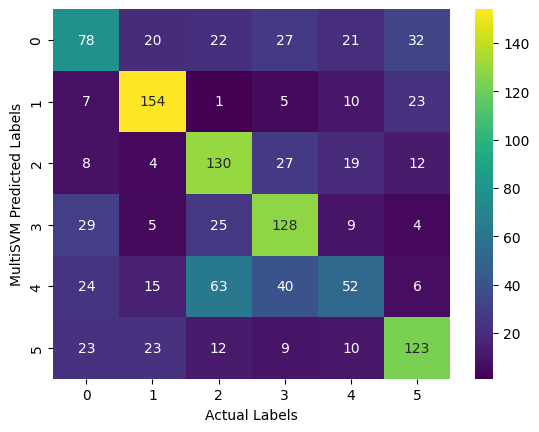

In [132]:
sns.heatmap(cm_cvxreich, annot=True, fmt='g', xticklabels=np.arange(6), yticklabels=np.arange(6), cmap='viridis')
plt.ylabel('MultiSVM Predicted Labels')
plt.xlabel('Actual Labels')

Text(0.5, 23.52222222222222, 'Actual Labels')

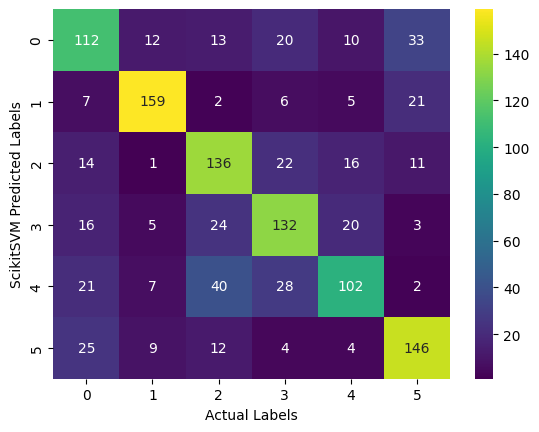

In [133]:
sns.heatmap(cm_sklreich, annot=True, fmt='g', xticklabels=np.arange(6), yticklabels=np.arange(6), cmap='viridis')
plt.ylabel('ScikitSVM Predicted Labels')
plt.xlabel('Actual Labels')

which into which missclassify? 12 ex of wrongs. comment

For ex:
- We see a lot of 4 is classified into: 2,3 by SKL and 0,2 by MultiSVM (4 and 2 might be similar labels)
- A lot of 5 is predicted as 0 by both models

In [176]:
idx_miscls = np.arange(len(y_val_full))[(y_val_full.flatten() != y_predv_skl_full)]
idx_miscls = np.random.choice(idx_miscls,12)

x_miscls = X_val_full[idx_miscls]
x_miscls.shape

(12, 768)

In [177]:
for i in range(12):
    miss = (x_miscls[i]*255).reshape(16,16,3)
    # print(sv6.shape)
    miss = miss.astype(np.uint8)
    img_sv = Image.fromarray(miss)
    img_sv.save(f"./q2nc/mis/q2nc_mislabel{i}.png")

(d) K-fold CV accuracy

In [186]:
from sklearn.model_selection import KFold

In [ ]:
# Accuracies on X, y (2 labels only) =>

# [0.48613445378151265,
#  0.49495798319327733,
#  0.8804621848739496,
#  0.8888655462184873,
#  0.8932773109243698,
#  0.9039915966386554]

In [193]:
C_list = [1e-5,1e-3,1,5,10,100]
kf = KFold(n_splits=5, shuffle=True)

X_kf = X_full
y_kf = y_full.flatten()

t0 = time.time()

accu_kfold = []
for C in C_list:
    svm_schies = svm.SVC(C=C,gamma=0.001)
    
    scores = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X_kf)):
        svm_schies.fit(X_kf[train_idx], y_kf[train_idx])
        score = svm_schies.score(X_kf[test_idx],y_kf[test_idx])
        scores.append(score)

        print(f"Fold {i+1} done for C={C}, at time {time.time()-t0}")
    
    scores = np.array(scores)
    accu_kfold.append(np.mean(scores))

print("Total time to generate 5-fold cv scores for C values on complete dataset = ", time.time()-t0)
accu_kfold

Fold 1 done for C=1e-05
Fold 2 done for C=1e-05
Fold 3 done for C=1e-05
Fold 4 done for C=1e-05
Fold 5 done for C=1e-05
Fold 1 done for C=0.001
Fold 2 done for C=0.001
Fold 3 done for C=0.001
Fold 4 done for C=0.001
Fold 5 done for C=0.001
Fold 1 done for C=1
Fold 2 done for C=1
Fold 3 done for C=1
Fold 4 done for C=1
Fold 5 done for C=1
Fold 1 done for C=5
Fold 2 done for C=5
Fold 3 done for C=5
Fold 4 done for C=5
Fold 5 done for C=5
Fold 1 done for C=10
Fold 2 done for C=10
Fold 3 done for C=10
Fold 4 done for C=10
Fold 5 done for C=10
Fold 1 done for C=100
Fold 2 done for C=100
Fold 3 done for C=100
Fold 4 done for C=100
Fold 5 done for C=100
Total time to generate 5-fold cv scores on complete dataset =  -1567.8991873264313


[0.15875350140056022,
 0.15518207282913166,
 0.5472689075630253,
 0.5780112044817928,
 0.5908963585434174,
 0.6238795518207283]

Text(0, 0.5, 'Accuracy')

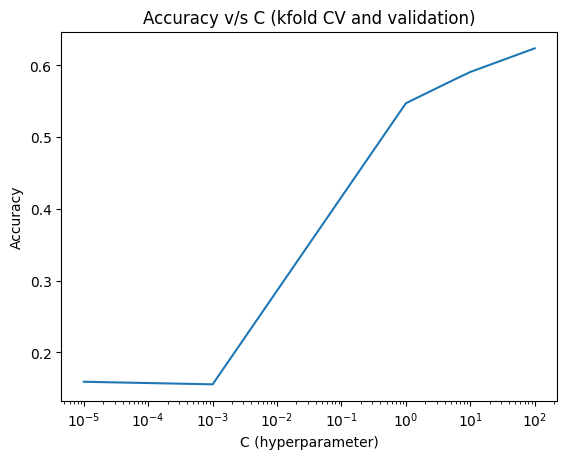

In [208]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(C_list,accu_kfold,label='Kfold CV')

ax.set_title("Accuracy v/s C (kfold CV and validation)")
ax.set_xlabel("C (hyperparameter)")
ax.set_ylabel("Accuracy")

In [199]:
t0 = time.time()

accu_valk = []
for C in C_list:
    svm_schies = svm.SVC(C=C,gamma=0.001)
    
    svm_schies.fit(X_full,y_full.flatten())
    score = svm_schies.score(X_val_full, y_val_full.flatten())

    print(f"{C} done")
    accu_valk.append(score)

print("Total time to generate val-scores for C values on complete dataset = ", time.time()-t0)

1e-05 done
0.001 done
1 done
5 done
10 done
100 done
Total time to generate val-scores for (5)C values on complete dataset =  423.3116888999939


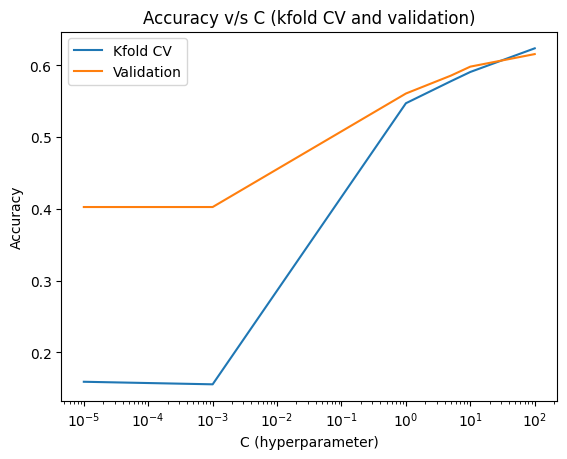

In [209]:
ax.plot(C_list,accu_valk,label='Validation')
ax.legend()
ax.figure

In [215]:
print("Accuracy for C=1:",accu_kfold[2],accu_valk[2])
print("Best accuracy (for C=10):",accu_kfold[-2],accu_valk[-2])

Accuracy for C=1: 0.5472689075630253 0.5608333333333333
Best accuracy (for C=10): 0.5908963585434174 0.5983333333333334


We see that out of C = [1e-5,1e-2,1,5,10], we obtain the best accuracy for C=10 in case of both Kfold cross-validation and train-test validation.

PS: Upon going higher, we see it still increases for C=100 in both metrics.